In [2]:
import datetime
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, TimestampType

# URL de la API de CoinGecko para obtener datos en tiempo real de Bitcoin
api_url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"

# Crear una lista vacía para almacenar los valores acumulados
accumulated_values = []
timestamps = []

# Definir la función para obtener el precio actual de Bitcoin
def get_current_price():
    response = requests.get(api_url)
    data = response.json()
    return float(data["bitcoin"]["usd"])

# Definir la función para procesar cada lote de datos
def process_stream(batch_df, batch_id):
    global accumulated_values, timestamps

    # Obtener el valor actual
    current_price = get_current_price()

    # Agregar el valor actual a la lista acumulada
    accumulated_values.append(current_price)
    timestamps.append(datetime.datetime.now())

    # Trazar la evolución acumulada
    plt.plot(timestamps, accumulated_values)

    # Configurar el formato del eje X como horas
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.xlabel("Tiempo")
    plt.ylabel("Valor acumulado")
    plt.title("Evolución acumulada de Bitcoin en tiempo real")

    plt.gcf().autofmt_xdate()  # Rotar las etiquetas del eje X para una mejor visualización
    plt.show()


In [3]:

# Iniciar SparkSession
spark = SparkSession.builder \
    .appName("Bitcoin Streaming Example") \
    .getOrCreate()

# Crear una función UDF para obtener el precio actual de Bitcoin
get_current_price_udf = udf(get_current_price, FloatType())

# Leer los datos en streaming utilizando una fuente de datos artificial (rate)
streaming_df = spark.readStream \
    .format("rate") \
    .option("rowsPerSecond", 1) \
    .load()

# Agregar una columna con el precio actual de Bitcoin
streaming_df = streaming_df.withColumn("bitcoin_price", get_current_price_udf())

23/09/20 20:44:04 WARN Utils: Your hostname, EliteX2 resolves to a loopback address: 127.0.1.1; using 192.168.5.94 instead (on interface wifi0)
23/09/20 20:44:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/20 20:44:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


23/09/20 20:44:12 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-650d1984-12b5-42d3-8163-562fa93a2130. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/09/20 20:44:12 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


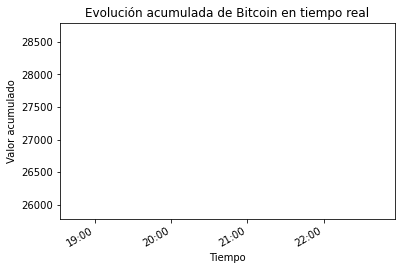

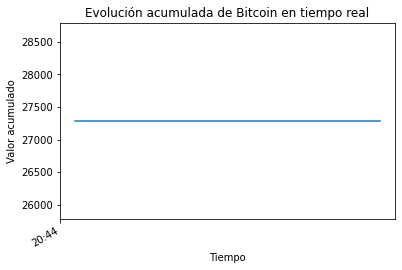

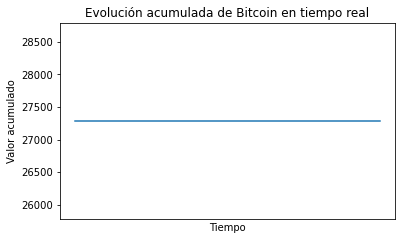

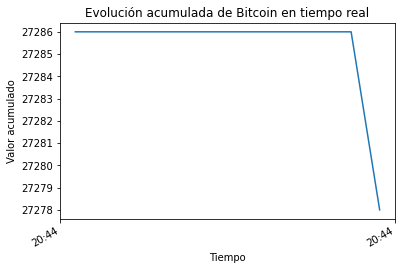

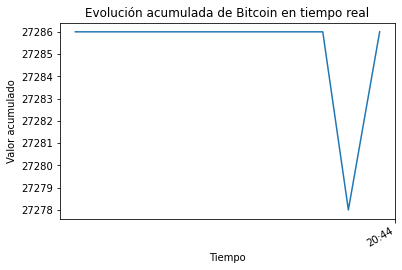

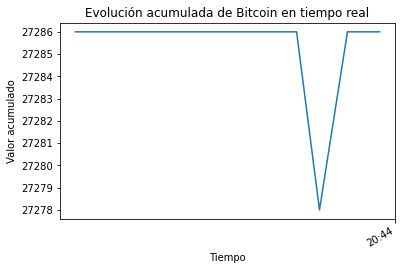

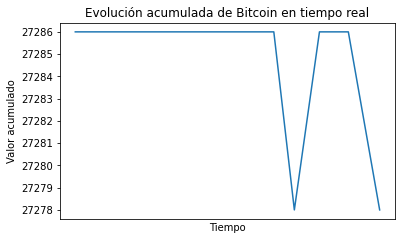

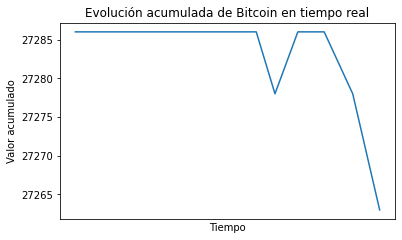

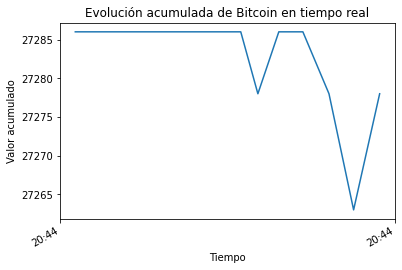

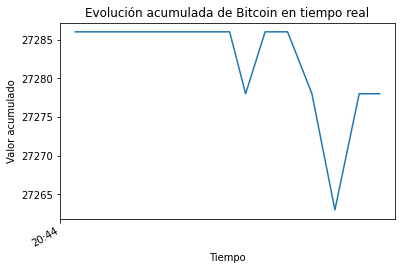

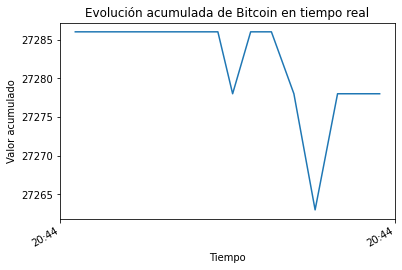

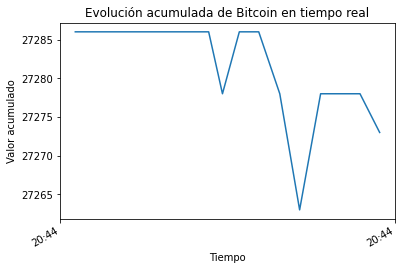

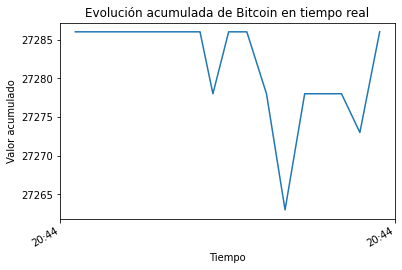

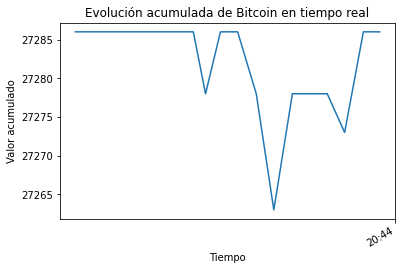

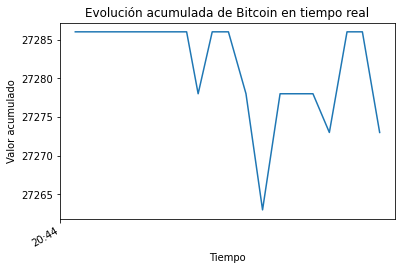

23/09/20 20:44:35 ERROR MicroBatchExecution: Query [id = e946ae4f-4540-48ec-8f2e-73d269cd36da, runId = c45b7b0a-1c7f-4fe1-b2ec-7fd859822664] terminated with error
py4j.Py4JException: An exception was raised by the Python Proxy. Return Message: Traceback (most recent call last):
  File "/home/jgm/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/home/jgm/.local/lib/python3.10/site-packages/pyspark/sql/utils.py", line 114, in call
    raise e
  File "/home/jgm/.local/lib/python3.10/site-packages/pyspark/sql/utils.py", line 111, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/tmp/ipykernel_30922/2905955895.py", line 27, in process_stream
    current_price = get_current_price()
  File "/tmp/ipykernel_30922/2905955895.py", line 20, in get_current_price
    return float(data["bitcoin"]["usd"])
KeyError: 'bitcoin'

	at py4j.Protocol.getReturnValue(Protocol.ja

StreamingQueryException: [STREAM_FAILED] Query [id = e946ae4f-4540-48ec-8f2e-73d269cd36da, runId = c45b7b0a-1c7f-4fe1-b2ec-7fd859822664] terminated with exception: An exception was raised by the Python Proxy. Return Message: Traceback (most recent call last):
  File "/home/jgm/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/home/jgm/.local/lib/python3.10/site-packages/pyspark/sql/utils.py", line 114, in call
    raise e
  File "/home/jgm/.local/lib/python3.10/site-packages/pyspark/sql/utils.py", line 111, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/tmp/ipykernel_30922/2905955895.py", line 27, in process_stream
    current_price = get_current_price()
  File "/tmp/ipykernel_30922/2905955895.py", line 20, in get_current_price
    return float(data["bitcoin"]["usd"])
KeyError: 'bitcoin'


In [4]:
spark.conf.set("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true")
# Ejecutar la consulta en streaming
query = streaming_df.writeStream \
    .outputMode("update") \
    .foreachBatch(process_stream) \
    .start()

# Esperar a que termine la consulta
query.awaitTermination()